In [3]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

In [5]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(3923881)

/opt/anaconda3/lib/python3.13/site-packages/mplsoccer/soccer/statsbomb.py:513: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['timestamp'] = pd.to_datetime(df['timestamp']).dt.time


In [11]:
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "Côte d'Ivoire"].iloc[0]["index"]
mask_cdm = (df.type_name == 'Pass') & (df.team_name == "Côte d'Ivoire") & (df.index < sub) & (df.outcome_name.isnull())

df_pass = df.loc[mask_cdm, ['x', 'y', 'end_x', 'end_y', "player_name", 'pass_recipient_name']]
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] =df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

In [15]:
scatter_df = pd.DataFrame()

for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name

    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))

    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)



In [17]:
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()

lines_df.rename({
    'x' : 'pass_count'
},
axis= 'columns',
inplace=True
)

lines_df = lines_df[lines_df['pass_count'] > 2]

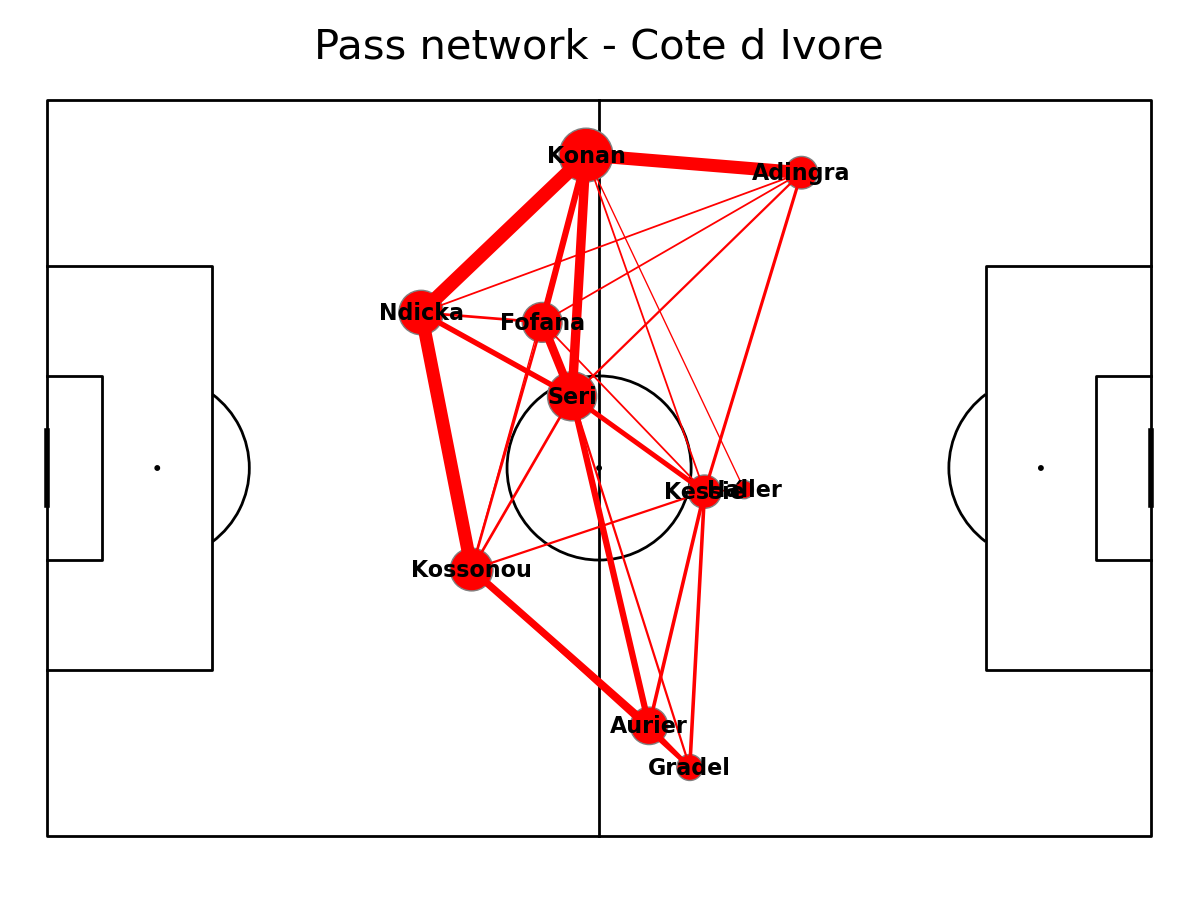

In [27]:
pitch = Pitch(line_color='black')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False, endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"])

# display player passes (only circles)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight='bold', size=16, ax=ax["pitch"], zorder=5)

# display passes network
for i, row in lines_df.iterrows():
    player1 = row["pair_key"].split("_")[0]
    player2 = row["pair_key"].split("_")[1]

    player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
    player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
    player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
    player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
    num_passes = row["pass_count"]

    line_width = (num_passes / lines_df["pass_count"].max() * 10)
    pitch.lines(player1_x, player1_y, player2_x, player2_y, alpha=1, lw= line_width, zorder=2, color='red', ax= ax["pitch"])

fig.suptitle("Pass network - Cote d Ivore", fontsize=30)
plt.show()